# Text Mining - Evaluación
---

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob).
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Instalaciones

In [ ]:
!pip install emoji_extractor
!pip install emoji
!python -m spacy download es_core_news_sm
!pip install deep_translator

  Preparing metadata (setup.py) ... done
  Created wheel for emoji_extractor: filename=emoji_extractor-2.0.0-py3-none-any.whl size=64157 sha256=1a25083e062f39c8afddb07166f95e540c5f40ad3c9f920c19d4d4797a1b6224
  Stored in directory: /root/.cache/pip/wheels/14/89/95/33d1b161e1daa8fb2dec089e887d3620d3a318fdb0798e9f58
Successfully built emoji_extractor
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=7929bff003b510c01a995afe70a576d1a2757ca91f73486df971393024cb511d
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji
2023-07-18 20:43:28.928975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in othe

## 1. Descargas

In [ ]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: profner/subtask-1/test-background-txt-files/1243953060050763778.txt  
  inflating: profner/subtask-1/test-background-txt-files/1243988693947486209.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244173600753618945.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244319340062822405.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247000104193712129.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247263989249212416.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247465550931988482.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249075777544556545.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249253729720766466.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249964965546668034.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249980196838682624.txt  
  inflating: profner/subta

In [ ]:
# Download emoji sentiment
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip


--2023-07-18 20:45:32--  https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
Resolving www.clarin.si (www.clarin.si)... 95.87.154.205
Connecting to www.clarin.si (www.clarin.si)|95.87.154.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘allzip’

allzip                  [   <=>              ]  94.61K   219KB/s    in 0.4s    

2023-07-18 20:45:34 (219 KB/s) - ‘allzip’ saved [96878]

Archive:  allzip
  inflating: ESR_v1.0_format.txt     
  inflating: Emoji_Sentiment_Data_v1.0.csv  
  inflating: Emojitracker_20150604.csv  


## 2. Imports

In [ ]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
from emoji_extractor.extract import Extractor

from deep_translator import GoogleTranslator
translator = GoogleTranslator(source="en", target="es")

import spacy
import es_core_news_sm
nlp = spacy.load('es_core_news_sm')
stop_words = spacy.lang.es.stop_words.STOP_WORDS
punctuations = string.punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

## 3. Funciones

In [ ]:
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt
    que se introduce en su entrada.
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()

  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

In [ ]:
# Preparar diccionario de emojis
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

# Calcula el sentimiento de los emojis de una lista utilizando el diccionario
# de emoji sentiment score generado previamente con la función load_emoji_sentiment()
# Se puede extraer el valor de positividad de los emojis con la option "positive"
# Se puede extraer el valor de neutralidad de los emojis con la option "neutral""
# Se puede extraer el valor de e negatividad de los emojis con la option "negative""

def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e:
      continue
  return output

# Eliminar los emojis de un texto. Esto es útil porque una vez extraido los emojis
# puede interesarnos tener un texto sin presencia de emojis para mejor análisis.
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C'
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199'
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

def get_emoji_name(lista):
  lista_name = []
  emoji_dict = {}
  longitud = len(lista)

  if longitud > 0:
    for emoji in lista:
      if emoji in emoji_sent_dict:
        emoji_dict = emoji_sent_dict[emoji]
        lista_name.append(translator.translate(emoji_dict.get("Unicode name")))

  return lista_name

In [ ]:
# Eliminar URLs
def quitar_urls(text):
    text = re.sub(r"\S*https?:\S*", "url", text, flags=re.MULTILINE)
    return text

# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

def tokenizer(sentence):
    # Eliminamos espacios
    texto = eliminar_espacios(sentence)

    # Pasamos la frase por el objeto nlp para procesarla
    mytokens = nlp(texto)

    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Quitamos las stopwords
    mytokens = [ word for word in mytokens if word not in stop_words ]

    # Eliminamos URLs
    mytokens = [ quitar_urls(word) for word in mytokens ]

    # Eliminar signos de puntuación de una lista de tokens (alfanumérico)
    mytokens = [ word for word in mytokens if word.isalnum()]
    #mytokens = [ word for word in mytokens if word not in string.punctuation]

    # Eliminamos digitos
    mytokens = [ word for word in mytokens if not word.isdigit() ]

    # devolver una lista de tokens
    return mytokens


## 4. Obtención del corpus

> Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [ ]:
datos_ejercicio.head(4)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


> Veamos unos ejemplos de tweets con label 0:

In [ ]:
pd.set_option('display.max_colwidth', 280)
df_0 = datos_ejercicio[datos_ejercicio['label']==0][['tweet_text', 'label']].head(5)
df_0.style.set_properties(subset=['tweet_text'], **{'text-align': 'left'})

,tweet_text,label
0,CHINA: libera una pandemia EE.UU: libera OVNIS ARGENTINA: libera presos Jajajajajajaja,0
1,San Francisco (EEUU) hace 100 años tras vivir la pandemia de 1918. https://t.co/veOT7nkdi8,0
2,Porfi poneos la mascarilla o tendremos 28 nuevas canciones de artistas colaborando con Rozalén.,0
3,El nuevo „covid normas y reglas recibimiento“ en el comercio minorista español. Pateando desde @mkdirecto un día mas las calles y tiendas de Madrid para conocer y mostrar la nueva „consumo normalidad“: https://t.co/EPrZ9Ncb5m,0
4,"Si el confinamiento ha dejado algo tocada tu estabilidad mental, siempre puedes consolarte pensando que Miguel Bosé ha quedado mucho peor.",0


> Y con label 1:

In [ ]:
df_1 = datos_ejercicio[datos_ejercicio['label']==1][['tweet_text', 'label']].head(5)
df_1.style.set_properties(subset=['tweet_text'], **{'text-align': 'left'})

,tweet_text,label
8,"Repartidores teniendo que trabajar en medio de una pandemia que nos tiene a todos encerrados y le meten 1.500€ de multa por aparcar en raya amarilla, hace falta ser cerdo de mierda, sin más.",1
9,"@carlesenric @salvadorilla Es imprescindible desescalada, con criterios sanitarios, no politicos,con gestores como minimo con cv como en Italia,no se puede poner en riesgo a la poblacion, buscando apoyos politicos..sres estamos ante una pandemia",1
17,"El mismo esfuerzo que heces tu , que ni te abres la puerta de tu coche oficial y cobras tu sueldo integro no como los millones de españoles afectados por los ERTE o de los autónomos que págamos sin cobrar, ni eres ni fuiste nunca clase trabajadora",1
18,Contexto: - Comisaría con cajas de mascarillas en puerta - Viene político y prensa para la grabación del evento - En la primera toma se dan cuenta que no lleva mascarilla - Repiten toma - Se introducen cajas en vehículo y se marchan 👉¿En manos de quiénes estamos? https://t.co/OcF8xZPpoS,1
19,"Que la directora del Centro Nacional de Epidemiología diga “desde el 1 de febrero, es decir, desde que tenemos la epidemia en nuestro país” ¿lo tomamos como fake? ¿lapsus? ¿sologripismo? Es que me acabo liando. https://t.co/ewd2Czc34q",1


> En este último ejemplo, vemos algunas menciones a profesionales, tales como: repartidores, políticos, gestores, directora.

> Cargamos también el diccionario de sentimientos de Twitter



In [ ]:
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")

In [ ]:
emoji_sent_dict["😍"]

{'Unicode codepoint': '0x1f60d',
 'Occurrences': 6359,
 'Position': 0.765292366,
 'Negative': 0.05173769460607014,
 'Neutral': 0.218587828274886,
 'Positive': 0.7296744771190439,
 'Unicode name': 'SMILING FACE WITH HEART-SHAPED EYES',
 'Unicode block': 'Emoticons'}

## 5. Análisis exploratorio

> **Número de documentos y columnas:**

> Veamos cuántas filas tenemos en el dataframe:







In [ ]:
print("Tenemos un conjunto de {} documentos".format(len(datos_ejercicio)))
print("El dataframe tiene {} columnas".format(datos_ejercicio.shape[1]))

Tenemos un conjunto de 8000 documentos
El dataframe tiene 4 columnas


> **Número de documentos duplicados:**

> Veamos si hay valores duplicados:


In [ ]:
print("Existen {} tweets duplicados".format(np.sum(datos_ejercicio.duplicated(subset=["tweet_text"]))))

Existen 0 tweets duplicados


> **Valores vacíos:**

> Vemos si no hay valores nulos en el texto del tweet, del label o del set

In [ ]:
print("Hay:\n{} valores vacíos en los tweets\n{} valores vacíos en las etiquetas\n{} valores vacíos en los sets".format(np.sum(datos_ejercicio.isnull())[1],
                                                                                                                      np.sum(datos_ejercicio.isnull())[2],
                                                                                                                      np.sum(datos_ejercicio.isnull())[3]))

Hay:
0 valores vacíos en los tweets
0 valores vacíos en las etiquetas
0 valores vacíos en los sets


> **Número de documentos por cada clase:**


> Contamos el número de elementos de cada clase. Cada clase significa lo siguiente:

> - Label = 1: representa la presencia de menciones de profesiones en el tweet.

> - Label = 0: representa la ausencia de menciones de profesiones en el tweet.

> Veamos cómo se distribuyen las clases:

> *   En cantidades


In [ ]:
datos_ejercicio["label"].value_counts()

0    6130
1    1870
Name: label, dtype: int64

> *   En porcentajes

In [ ]:
datos_ejercicio["label"].value_counts(normalize=True)

0    0.76625
1    0.23375
Name: label, dtype: float64

> Tenemos un dataset desbalanceado:

> La clase 0 corresponde al 76.6% de la base

> La clase 1 tiene el 23.4% de la base

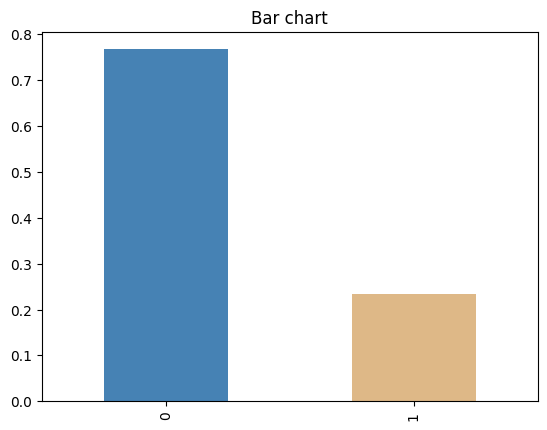

In [ ]:
ax, fig = plt.subplots()
etiquetas = datos_ejercicio.label.value_counts(normalize=True)
etiquetas.plot(kind= 'bar', color= ["steelblue", "burlywood"])
plt.title('Bar chart')
plt.show()

> **Distribución de la longitud de los tweet en caracteres:**

> Calculemos la longitud de cada uno de los textos de los documentos.

> Comenzamos creando las columnas que van a almacenar la longitud en caracteres de los documentos del corpus:

In [ ]:
datos_ejercicio["char_len"] = datos_ejercicio["tweet_text"].apply(lambda x: len(x))

<Figure size 1400x1200 with 0 Axes>

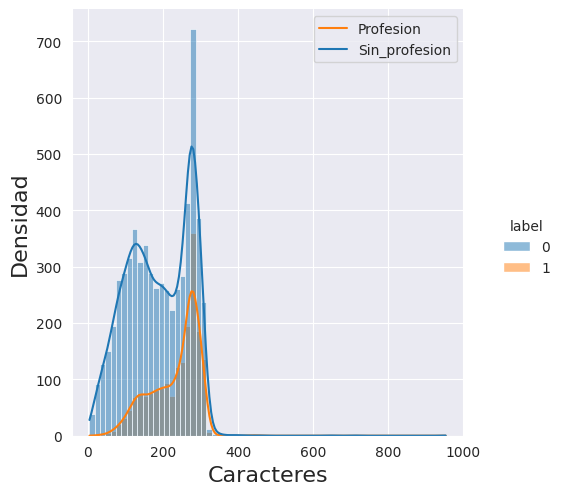

In [ ]:
#sns.displot(data=datos_ejercicio, x="char_len", hue="label", kind="kde")
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=datos_ejercicio, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["Profesion", "Sin_profesion"])

# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

> En la figura se ve que no existen diferencias significativas entre las dos clases, teniendo en cuenta la longitud del texto. Tal vez haya más cantidad de tweets cortos en la clase cero (sin profesiones), pero no como para separar clases por longitudes de tweets.

## 6. Preprocesado y normalización

> Primeramente, trabajaremos con los emojis. Extraemos los emojis con nuestra función previamente definida:


In [ ]:
datos_ejercicio["emoji_list"] = datos_ejercicio["tweet_text"].apply(lambda x: extract_emojis(x))

> Comprobamos lo que hemos guardado


In [ ]:
datos_ejercicio[datos_ejercicio["emoji_list"].str.len()>0]["emoji_list"].head(7)

18         [👉]
23    [🇺🇸, 🇪🇸]
26      [📌, 💪]
29         [▶]
36         [➡]
37         [🚨]
40         [🔴]
Name: emoji_list, dtype: object

> Veamos qué emoticones están más relacionados con cada clase.

> Para ello, obtenemos los nombres de cada emoticón y lo traducimos al español. Luego lo graficamos con un word cloud.

In [ ]:
datos_ejercicio["emoji_names"] = datos_ejercicio["emoji_list"].apply(lambda x: get_emoji_name(x))

> Veamos los emoticones relacionados con las menciones a profesiones:

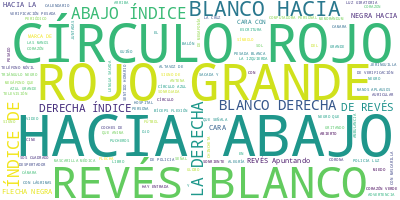

In [ ]:
from wordcloud import WordCloud
datos_ejercicio["emoji_text"] = datos_ejercicio["emoji_names"].apply(lambda x: " ".join(x))
emo1 = datos_ejercicio[datos_ejercicio["label"]==1]
str1 = ','.join(list(emo1["emoji_text"].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
wordcloud.generate(str1)
wordcloud.to_image()

> Y los que están relacionados con la ausencia de menciones a profesiones:

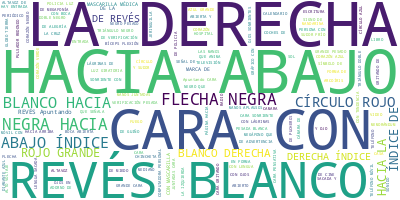

In [ ]:
from wordcloud import WordCloud
emo0 = datos_ejercicio[datos_ejercicio["label"]==0]
str0 = ','.join(list(emo0["emoji_text"].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
wordcloud.generate(str0)
wordcloud.to_image()

> *   La clase 1 (con menciones) está más asociada a emoticones de: círculo rojo, hacia abajo, rojo grande, revés blanco, etc.
> *   La clase 0 (sin menciones) está más asociada a emoticones de: hacia abajo, la derecha, cara con, revés blanco, etc.

> A continuación, asociaremos un score de sentimiento a cada emoji correspondiente a cada tweet:

In [ ]:
datos_ejercicio["sent_emoji_pos"] = datos_ejercicio["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "positive"))
datos_ejercicio["sent_emoji_neu"] = datos_ejercicio["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
datos_ejercicio["sent_emoji_neg"] = datos_ejercicio["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "negative"))

> Echemos un vistazo a los scores generados:

In [ ]:
datos_ejercicio[datos_ejercicio['emoji_list'].str.len()>0][['emoji_list', 'sent_emoji_pos',	'sent_emoji_neu',	'sent_emoji_neg']].head(5)

,emoji_list,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg
18,[👉],0.462329,0.469178,0.068493
23,"[🇺🇸, 🇪🇸]",0.000000,0.000000,0.000000
26,"[📌, 💪]",0.770252,0.443780,0.785968
29,[▶],0.267176,0.679389,0.053435
36,[➡],0.157658,0.833333,0.009009


> Como siguiente paso, quitaremos estos emojis de los tweets, y los sustituiremos por sus significados en texto traducidos al español.

In [ ]:
# Quitar emojis de los textos
datos_ejercicio["tweet_procesado"] = datos_ejercicio["tweet_text"].apply(lambda x: clean_emoji(x))

# Concatenar el significado de los emojis
datos_ejercicio["tweet_procesado"] = datos_ejercicio["emoji_text"].str.cat(datos_ejercicio["tweet_procesado"])

> Veamos un ejemplo de este tweet procesado:

In [ ]:
df_emo = datos_ejercicio[datos_ejercicio['emoji_list'].str.len()>0][['tweet_text', 'tweet_procesado']].tail(5)
df_emo.style.set_properties(subset=['tweet_text', 'tweet_procesado'], **{'text-align': 'left'})

,tweet_text,tweet_procesado
7990,"📰 VOX denuncia un nuevo recorte del @psoemerida en los servicios esenciales. 👉 ""Exigimos reducir el gasto superfluo, subvenciones a partidos, sindicatos y ONGs que no estén destinadas a paliar efectos del Coronavirus, para destinar esos recursos a potenciar servicios sociales""","PERIÓDICO BLANCO DERECHA ÍNDICE DE REVÉS Apuntando VOX denuncia un nuevo recorte del @psoemerida en los servicios esenciales. ""Exigimos reducir el gasto superfluo, subvenciones a partidos, sindicatos y ONGs que no estén destinadas a paliar efectos del Coronavirus, para destinar esos recursos a potenciar servicios sociales"""
7991,"🎙#LasAlasDeLaConciencia Lunes 22 17hs #OmarGrillo #Vacunas #Autismo #Covid en #LaFalda #NoticiasSocioAmbientales, #MoniJeanson y #Wionak #BloqueIgualdad, #CarlosRon #BloqueHumorístico, #JaviNepo #BloqueHistórico, #MatíasRuiz #BloqueTaaaLoooco, #ElTucu https://t.co/wacrBRpVmC https://t.co/6MQFArZ1Gc","#LasAlasDeLaConciencia Lunes 22 17hs #OmarGrillo #Vacunas #Autismo #Covid en #LaFalda #NoticiasSocioAmbientales, #MoniJeanson y #Wionak #BloqueIgualdad, #CarlosRon #BloqueHumorístico, #JaviNepo #BloqueHistórico, #MatíasRuiz #BloqueTaaaLoooco, #ElTucu https://t.co/wacrBRpVmC https://t.co/6MQFArZ1Gc"
7993,"$100.000 recaudados en los #CalvoGames para la lucha contra el COVID-19 y pasó. Oficialmente somos, El Escuadrón Calvón. ❤️👨🏻‍🦲 https://t.co/cDDThp0mzF","CORAZÓN NEGRO PESADO$100.000 recaudados en los #CalvoGames para la lucha contra el COVID-19 y pasó. Oficialmente somos, El Escuadrón Calvón. ️ ‍🦲 https://t.co/cDDThp0mzF"
7998,"El gobierno prohíbe por ley lis despidos durante la crisis del coronavirus, V🤮X vota en contra, los patriotas... #PomaditaYEscudoSocial https://t.co/avOmoXEOst","El gobierno prohíbe por ley lis despidos durante la crisis del coronavirus, V🤮X vota en contra, los patriotas... #PomaditaYEscudoSocial https://t.co/avOmoXEOst"
7999,Rasgos psicológicos de por qué no llevas #mascarilla 🤣 https://t.co/2dUSFMT6dw,Rasgos psicológicos de por qué no llevas #mascarilla 🤣 https://t.co/2dUSFMT6dw


> A continuación, tokenizamos los textos.

> En el proceso se incluyen: eliminar espacios, tokenizar, lematizar, pasar a minúsculas, quitar stopwords, eliminar signos de puntuación, eliminar dígitos y sustituir URLs por la palabra "URL".

In [ ]:
datos_ejercicio["tokenizado"] = datos_ejercicio["tweet_procesado"].apply(lambda x: tokenizer(x))

In [ ]:
pd.set_option('display.max_colwidth', 140)
datos_ejercicio[datos_ejercicio['emoji_list'].str.len()>0][['tweet_procesado', 'tokenizado']].head(5)

,tweet_procesado,tokenizado
18,BLANCO DERECHA ÍNDICE DE REVÉS ApuntandoContexto: - Comisaría con cajas de mascarillas en puerta - Viene político y prensa para la gra...,"[blanco, derecha, índice, revés, apuntandocontexto, comisacer, caja, mascarilla, puerta, venir, político, prensa, grabación, evento, tom..."
23,Embajador Buchan: la Embajada de EE. UU. en Madrid ha proyectado la bandera española en su fachada en solidaridad con el pueblo español ...,"[embajador, buchan, embajada, madrid, proyectar, bandera, español, fachada, solidaridad, pueblo, español, lucha, covid19, momento, oscur..."
26,"CHINCHETA BÍCEPS FLEXIÓN 7 Abril #diamundialdelasalud @WHO lo dedica a las enfermeras, con el lema ""Apoye a las enfermeras y matronas""...","[chincheta, bíceps, flexión, abril, diamundialdelasalud, dedicar, enfermera, lema, apoye, enfermera, matrona, destacar, objetivo, nursin..."
29,"TRIÁNGULO NEGRO QUE SEÑALA A LA DERECHA @IdiazAyuso en @elprogramadear: ""Hay que ir contra esta epidemia, evitar que esto vuelva a suce...","[triángulo, negro, señala, derecha, epidemia, evitar, volver, suceder, estrategia, país, url]"
36,FLECHA NEGRA HACIA LA DERECHA ️ La orden publicada el viernes en el @boe establece que las CCAA envíen datos más detallados para entende...,"[flecha, negra, derecha, orden, publicado, viernes, establecer, ccaa, enveir, dato, detallado, entender, evolución, covid19, ccaa, perio..."


> Veamos la distribución de frecuencias de los tokens

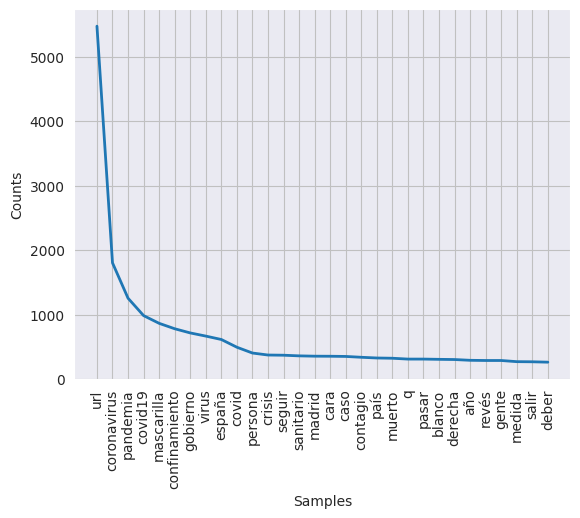

In [ ]:
import itertools
from nltk.probability import FreqDist

flat_list = itertools.chain(*datos_ejercicio["tokenizado"])
fdist = FreqDist(flat_list)
fdist.plot(30,cumulative=False)
plt.show()

> Los tokens más frecuentes son: URLs, coronavirus, pandemia, covid19, mascarilla, confinamiento. Podemos asumir, aunque no tengamos metadatos de fecha de creación de los tweets, que los mismos corresponden a época de pandemia.

> Veamos cuáles son los tokens más frecuentes en nuestro dataset según los labels:

> Label 1 (mención de profesiones)

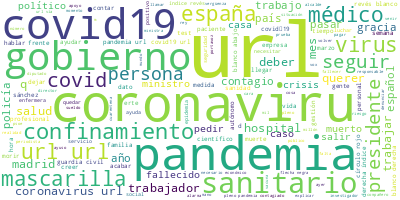

In [ ]:
datos_ejercicio["clean_text"] = datos_ejercicio["tokenizado"].apply(lambda x: " ".join(x))
df1 = datos_ejercicio[datos_ejercicio["label"]==1]
string1 = ','.join(list(df1["clean_text"].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
wordcloud.generate(string1)
wordcloud.to_image()

> Label 0 (sin mención de profesiones)

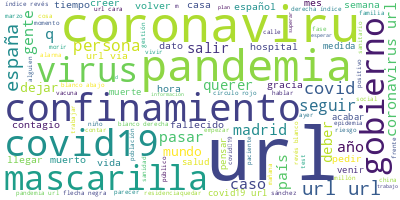

In [ ]:
df0 = datos_ejercicio[datos_ejercicio["label"]==0]
string0 = ','.join(list(df0["clean_text"].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
wordcloud.generate(string0)
wordcloud.to_image()

> Parece haber un solapamiento entre ambas clases, por lo menos en las palabras más frecuentes.

> En el siguiente paso, calcularemos los sentimientos de los textos.

> Para ello utilizaremos los datos de Spanish Emotion Lexicon de la web de Grigori Sidorov, que contiene 2036 paralabras asociadas con la medida de Factor de probabilidad de uso afectivo (PFA en inglés) con respecto a, al menos, una emoción básica: alegría, sorpresa, tristeza, enojo, miedo, repulsión.

In [ ]:
url_path = "https://www.cic.ipn.mx/~sidorov/SEL.txt"
sel_lexicon = pd.read_csv(url_path,sep="\t", encoding="latin-1")

> Veamos algunos ejemplos:

In [ ]:
sel_lexicon.head(3)

,Palabra,PFA,Categoría
0,abundancia,0.830,Alegría
1,acabalar,0.396,Alegría
2,acallar,0.198,Alegría


> Mapemos los sentimientos de la siguiente manera:

> *   Positivos: alegría, sorpresa
> *   Negativos: tristeza, enojo, miedo, repulsión


In [ ]:
dicc_mapping = {"Alegría":"positive",
                "Sorpresa":"positive",
                "Tristeza":"negative",
                "Enojo":"negative",
                "Miedo":"negative",
                "Repulsión":"negative"}

sel_lexicon["Categoría"] = sel_lexicon["Categoría"].map(dicc_mapping)

In [ ]:
positive_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="positive"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="positive"][' PFA']))
negative_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="negative"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="negative"][' PFA']))

In [ ]:
def calculate_sentiment(frase, positive_words, negative_words):
  """
  Función para calcular el score de sentimiento de una frase

  Args:
    frase [str]: Frase pre-preprocesada en español. Debe venir lematizada.
    positive_words [dict]: Diccionario de palabras positivas extraidas de SEL
    negative_words [dict]: Diccionario de palabras negativas extraídas de SEL

  Out:
    Sentiment score
  """
  score = 0
  for i in frase.split():
    if i in positive_words:
      score = score + float(positive_words[i])
    elif i in negative_words:
      score = score - float(negative_words[i])
    else:
      score = score + 0

  return score

> Aplicamos al texto procesado para obtener el sentimiento asociado:

In [ ]:
datos_ejercicio["pfa"] = datos_ejercicio["clean_text"].apply(lambda x: calculate_sentiment(x, positive_words, negative_words))

In [ ]:
datos_ejercicio[["clean_text", "pfa"]].head(5)

,clean_text,pfa
0,china liberar pandemia libera ovnis argentina libero preso jajajajajajaja,0.00
1,san francisco eeuu año vivir pandemia url,0.63
2,porfi poneo mascarilla canción artista colaborar rozalén,0.00
3,covid norma regla recibimiento comercio minorista español patear calle tienda madrid mostrar consumo normalidad url m,0.00
4,confinamiento dejar tocado estabilidad mental consolarte pensar miguel bosé quedar,0.33


<Axes: >

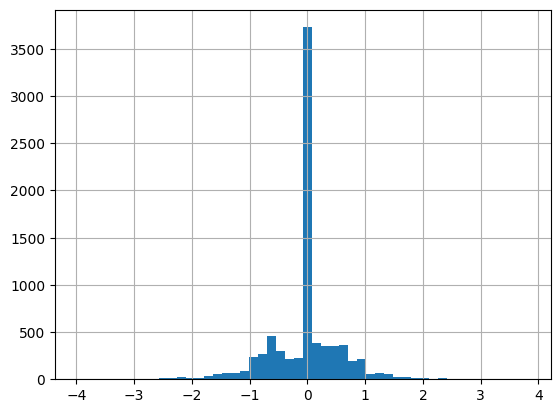

In [ ]:
datos_ejercicio["pfa"].hist(bins=50)

> Podemos ver que hay un pico de tweets neutros y una distribución similar entre sentimientos positivos y negativos.

## 7. Vectorización

> Utilizaremos TFIDFVectorizer para extraer las siguientes características: unigramas, bigramas y trigramas. No consideramos los elementos que salgan en menos del 0.1% de los documentos.

In [ ]:
vectorizador = TfidfVectorizer(min_df=0.001, ngram_range = (1,3))
vector_data = vectorizador.fit_transform(datos_ejercicio["clean_text"])

## 8. Entrenamiento y evaluación de modelos


> Incluiremos las características adicionales que hemos calculado, con el fin de mejorar el modelo. Para ello, utilizaremos la librería scipy y generaremos una matriz sparse que contenga tanto las características de TFIDF como las calculadas manualmente.

> Obtenemos las características que hemos calculado manualmente:

In [ ]:
extra_features = datos_ejercicio[['sent_emoji_pos','sent_emoji_neu','sent_emoji_neg', 'pfa']]

> Utilizamos la librería scipy para unir las características TFIDF (contenidas en vector_data) con las que acabamos de seleccionar (extra_features):

In [ ]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = datos_ejercicio["label"].values.astype(np.float32)

# Unimos las características TFIDF con las características previamente seleccionadas
X = sp.sparse.hstack((vector_data, extra_features.values),format='csr')

> Dividimos nuestro dataset en train y test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(6000, 2556)
(2000, 2556)


> Procedemos a gestionar el desbalanceo de clases en nuestro dataset de train:

In [ ]:
# Cargamos
from imblearn.over_sampling import SMOTE

# Creamos objetos
#sm = SMOTE(random_state=2, sampling_strategy="minority")
sm = SMOTE(random_state=2, sampling_strategy=0.4)

# Retransformamos
X_res, y_res = sm.fit_resample(X_train, y_train)

> Observamos el resultado del rebalanceo:

In [ ]:
from collections import Counter

print('Cantidad dataset original %s' % Counter(y_train))
print('Cantidad dataset rebalanceado %s' % Counter(y_res))

Cantidad dataset original Counter({0.0: 4587, 1.0: 1413})
Cantidad dataset rebalanceado Counter({0.0: 4587, 1.0: 1834})


> **Decisión de modelo de ML a utilizar**

> En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados.

> La función hace un KFold y evalúa diferentes modelos con una métrica de evaluación:

In [ ]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

> Una vez definida la función, podemos definir los modelos con los que hacer la evaluación.

> En este caso, evaluaremos la regresión logística, árboles de decisión, naive bayes y random forest.

In [ ]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic", LogisticRegression(random_state=30)),
         ("DecisionTree", DecisionTreeClassifier(random_state=0)),
         ("GaussianNB", GaussianNB()),
         ("RandomForest", RandomForestClassifier(random_state=30))
        ]

# evaluation_score = "f1"
evaluation_score = "accuracy"

model_evaluation(models, evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
Logistic: 0.818257 (0.014715) 
Metric: accuracy , KFold 
DecisionTree: 0.848935 (0.009446) 
Metric: accuracy , KFold 
GaussianNB: 0.540419 (0.026588) 
Metric: accuracy , KFold 
RandomForest: 0.891606 (0.006610) 


([array([0.79004666, 0.83021807, 0.81152648, 0.79595016, 0.82866044,
         0.81931464, 0.8317757 , 0.81931464, 0.81775701, 0.83800623]),
  array([0.83825816, 0.86448598, 0.83800623, 0.84735202, 0.85669782,
         0.85825545, 0.83489097, 0.85514019, 0.85202492, 0.84423676]),
  array([0.51321928, 0.5482866 , 0.49688474, 0.52336449, 0.56542056,
         0.53894081, 0.54205607, 0.58878505, 0.52024922, 0.56697819]),
  array([0.88958009, 0.88317757, 0.8847352 , 0.8894081 , 0.894081  ,
         0.8894081 , 0.88629283, 0.90654206, 0.89563863, 0.89719626])],
 ['Logistic', 'DecisionTree', 'GaussianNB', 'RandomForest'])

> Elegimos el mejor modelo: Random Forest, con un accuracy de 0.89

> Luego, definimos los parámetros para hacer un GridSearchCV:

In [ ]:
# Random Forest
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()

# Definimos el modelo y establecemos los parámetros
grid_param = {
    'n_estimators': [30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [15, 18, 20]
 }

model_grid = GridSearchCV(estimator=model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)


> Vamos a entrenar el GridSearch para obtener el mejor parámetro para nuestro conjunto de datos.

In [ ]:
grid_result = model_grid.fit(X_res, y_res)
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.784768 usando los parámetros {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 50}


> Entrenamos el modelo con los resultados ofrecidos por el GridSearch:

In [ ]:
# Random Forest
from sklearn.model_selection import (KFold, cross_val_score, cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=20, n_estimators=50) #, class_weight="balanced")
model.fit(X_res, y_res)

RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=50)

> Vamos a ver cómo funciona el modelo haciendo el predict del test y mostrando el classification_report y la matriz de confusión:

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      1543
         1.0       0.95      0.26      0.41       457

    accuracy                           0.83      2000
   macro avg       0.89      0.63      0.65      2000
weighted avg       0.85      0.83      0.79      2000



> El recall para nuestra clase de interés es de solo 26%, es decir, de los verdaderos 1, solo acierta en el 26% de los casos, aunque de los valores predichos acierte el 95% de las veces. En este caso, nos interesa mejorar el recall.

> Veamos gráficamente con la matriz de confusión

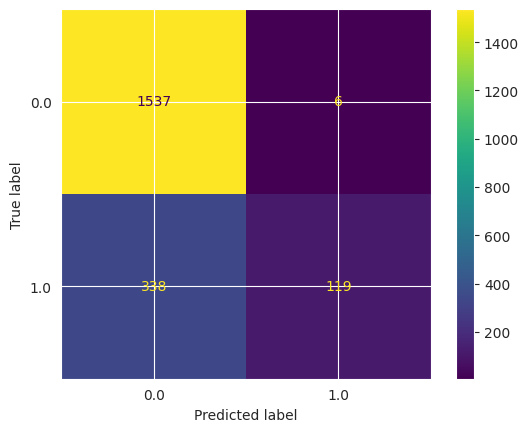

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None)

> Intentaremos mejorar el modelo, esta vez evaluando los mismos algoritmos, pero sin tener en cuenta el balanceo de clases.

In [ ]:
model_evaluation(models, evaluation_score, X_train.toarray(), y_train)

Metric: accuracy , KFold 
Logistic: 0.823500 (0.018730) 
Metric: accuracy , KFold 
DecisionTree: 0.841000 (0.016586) 
Metric: accuracy , KFold 
GaussianNB: 0.470667 (0.016162) 
Metric: accuracy , KFold 
RandomForest: 0.885167 (0.017614) 


([array([0.805     , 0.83333333, 0.80333333, 0.79833333, 0.83833333,
         0.84833333, 0.79833333, 0.84      , 0.83166667, 0.83833333]),
  array([0.79833333, 0.845     , 0.84666667, 0.85333333, 0.85833333,
         0.83      , 0.835     , 0.85333333, 0.83833333, 0.85166667]),
  array([0.46166667, 0.465     , 0.475     , 0.49      , 0.45      ,
         0.45333333, 0.48666667, 0.48833333, 0.44833333, 0.48833333]),
  array([0.85333333, 0.89166667, 0.865     , 0.90833333, 0.905     ,
         0.89      , 0.87333333, 0.895     , 0.87      , 0.9       ])],
 ['Logistic', 'DecisionTree', 'GaussianNB', 'RandomForest'])

> El mejor modelo sigue siendo el random forest, con un accuracy de 0.89

> Entrenamos nuevamente el GridSearch para obtener los mejores parámetros.

In [ ]:
grid_result2 = model_grid.fit(X_train, y_train)
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.803667 usando los parámetros {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 30}


> Entrenamos el modelo con los resultados ofrecidos por el GridSearch.

> Agregamos el parámetro class_weight, ya que estamos entrenando con clases desbalanceadas.

In [ ]:
# Random Forest
from sklearn.model_selection import (KFold, cross_val_score, cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model2 = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=20, n_estimators=30, class_weight="balanced")
model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       n_estimators=30)

> Vamos a ver cómo funciona el modelo haciendo el predict del test y mostrando el classification_report y la matriz de confusión:

In [ ]:
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      1543
         1.0       0.74      0.61      0.67       457

    accuracy                           0.86      2000
   macro avg       0.82      0.77      0.79      2000
weighted avg       0.86      0.86      0.86      2000



> Mejoramos el recall para nuestra clase de interés, pasando de 26% a 61%, con un f1-score de 0.67

> Veamos gráficamente con la matriz de confusión

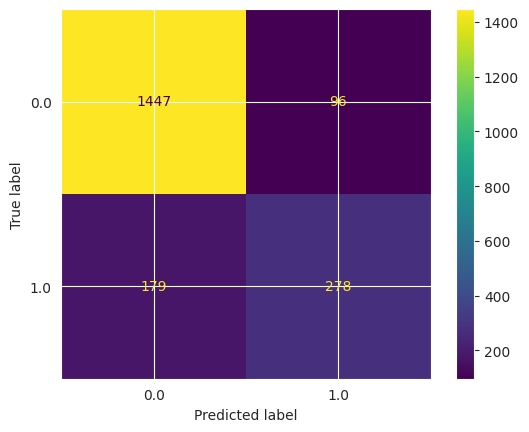

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model2, X_test, y_test, normalize = None)

> Nos quedamos con este último modelo, ya que predice un poco mejor la clase de interés 1, correspondiente a las menciones a profesiones en los tweets.